In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.2 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 2.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 34662 
    Total predicted counts          : 34977.88
    Total off counts                : 101898.00

    Total background counts         : 20379.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 5000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 30.9 s, sys: 185 ms, total: 31 s
Wall time: 34.6 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 35056 
    Total predicted counts          : 35011.28
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 34660 
    Total predicted counts          : 34896.08
    Total off counts                : 101489.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_12 

    Total counts                    : 34910 
    Total predicted counts          : 34967.48
    Total off counts                : 101846.00

    Total background counts         : 20369.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_13 

    Total counts                    : 35013 
    Total predicted counts          : 34905.08
    Total off counts                : 101534.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_23 

    Total counts                    : 34858 
    Total predicted counts          : 34937.48
    Total off counts                : 101696.00

    Total background counts         : 20339.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_24 

    Total counts                    : 34996 
    Total predicted counts          : 34854.88
    Total off counts                : 101283.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_37 

    Total counts                    : 34777 
    Total predicted counts          : 34988.28
    Total off counts                : 101950.00

    Total background counts         : 20390.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_38 

    Total counts                    : 34959 
    Total predicted counts          : 34854.08
    Total off counts                : 101279.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_52 

    Total counts                    : 34871 
    Total predicted counts          : 34930.48
    Total off counts                : 101661.00

    Total background counts         : 20332.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_53 

    Total counts                    : 35031 
    Total predicted counts          : 34986.48
    Total off counts                : 101941.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_64 

    Total counts                    : 34809 
    Total predicted counts          : 34872.48
    Total off counts                : 101371.00

    Total background counts         : 20274.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_65 

    Total counts                    : 34786 
    Total predicted counts          : 34876.08
    Total off counts                : 101389.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_76 

    Total counts                    : 34910 
    Total predicted counts          : 34953.88
    Total off counts                : 101778.00

    Total background counts         : 20355.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_77 

    Total counts                    : 34903 
    Total predicted counts          : 34897.88
    Total off counts                : 101498.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_89 

    Total counts                    : 34939 
    Total predicted counts          : 34813.28
    Total off counts                : 101075.00

    Total background counts         : 20215.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_90 

    Total counts                    : 34613 
    Total predicted counts          : 34997.88
    Total off counts                : 101998.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_104 

    Total counts                    : 34697 
    Total predicted counts          : 35004.48
    Total off counts                : 102031.00

    Total background counts         : 20406.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_105 

    Total counts                    : 34780 
    Total predicted counts          : 34974.68
    Total off counts                : 101882.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_117 

    Total counts                    : 34732 
    Total predicted counts          : 34902.28
    Total off counts                : 101520.00

    Total background counts         : 20304.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_118 

    Total counts                    : 35083 
    Total predicted counts          : 35012.68
    Total off counts                : 102072.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_130 

    Total counts                    : 34843 
    Total predicted counts          : 34832.48
    Total off counts                : 101171.00

    Total background counts         : 20234.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_131 

    Total counts                    : 34694 
    Total predicted counts          : 34877.68
    Total off counts                : 101397.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_144 

    Total counts                    : 34918 
    Total predicted counts          : 34975.88
    Total off counts                : 101888.00

    Total background counts         : 20377.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_145 

    Total counts                    : 34945 
    Total predicted counts          : 35014.48
    Total off counts                : 102081.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_161 

    Total counts                    : 35147 
    Total predicted counts          : 34927.68
    Total off counts                : 101647.00

    Total background counts         : 20329.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.01

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_162 

    Total counts                    : 35053 
    Total predicted counts          : 34885.88
    Total off counts                : 101438.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_174 

    Total counts                    : 35163 
    Total predicted counts          : 34858.28
    Total off counts                : 101300.00

    Total background counts         : 20260.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_175 

    Total counts                    : 35247 
    Total predicted counts          : 34919.28
    Total off counts                : 101605.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_193 

    Total counts                    : 34814 
    Total predicted counts          : 34933.48
    Total off counts                : 101676.00

    Total background counts         : 20335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_194 

    Total counts                    : 34727 
    Total predicted counts          : 34929.88
    Total off counts                : 101658.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_208 

    Total counts                    : 34740 
    Total predicted counts          : 34976.68
    Total off counts                : 101892.00

    Total background counts         : 20378.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_209 

    Total counts                    : 34972 
    Total predicted counts          : 34988.28
    Total off counts                : 101950.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_223 

    Total counts                    : 35098 
    Total predicted counts          : 34953.68
    Total off counts                : 101777.00

    Total background counts         : 20355.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_224 

    Total counts                    : 34874 
    Total predicted counts          : 34903.28
    Total off counts                : 101525.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_238 

    Total counts                    : 34761 
    Total predicted counts          : 34927.28
    Total off counts                : 101645.00

    Total background counts         : 20329.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_239 

    Total counts                    : 35029 
    Total predicted counts          : 34973.48
    Total off counts                : 101876.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_252 

    Total counts                    : 34774 
    Total predicted counts          : 34966.88
    Total off counts                : 101843.00

    Total background counts         : 20368.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_253 

    Total counts                    : 34710 
    Total predicted counts          : 34881.88
    Total off counts                : 101418.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_265 

    Total counts                    : 34910 
    Total predicted counts          : 34921.08
    Total off counts                : 101614.00

    Total background counts         : 20322.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_266 

    Total counts                    : 34791 
    Total predicted counts          : 34959.08
    Total off counts                : 101804.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_278 

    Total counts                    : 35087 
    Total predicted counts          : 34868.88
    Total off counts                : 101353.00

    Total background counts         : 20270.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_279 

    Total counts                    : 35140 
    Total predicted counts          : 35007.88
    Total off counts                : 102048.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_290 

    Total counts                    : 34925 
    Total predicted counts          : 34986.48
    Total off counts                : 101941.00

    Total background counts         : 20388.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_291 

    Total counts                    : 34963 
    Total predicted counts          : 34935.28
    Total off counts                : 101685.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_302 

    Total counts                    : 34792 
    Total predicted counts          : 34930.48
    Total off counts                : 101661.00

    Total background counts         : 20332.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_303 

    Total counts                    : 34764 
    Total predicted counts          : 34885.48
    Total off counts                : 101436.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_316 

    Total counts                    : 34853 
    Total predicted counts          : 34853.68
    Total off counts                : 101277.00

    Total background counts         : 20255.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_317 

    Total counts                    : 34819 
    Total predicted counts          : 34908.08
    Total off counts                : 101549.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_329 

    Total counts                    : 34672 
    Total predicted counts          : 34868.28
    Total off counts                : 101350.00

    Total background counts         : 20270.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_330 

    Total counts                    : 34889 
    Total predicted counts          : 34987.08
    Total off counts                : 101944.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_342 

    Total counts                    : 34874 
    Total predicted counts          : 34960.88
    Total off counts                : 101813.00

    Total background counts         : 20362.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_343 

    Total counts                    : 35038 
    Total predicted counts          : 34921.48
    Total off counts                : 101616.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_358 

    Total counts                    : 35003 
    Total predicted counts          : 34875.68
    Total off counts                : 101387.00

    Total background counts         : 20277.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_359 

    Total counts                    : 34770 
    Total predicted counts          : 34966.88
    Total off counts                : 101843.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_371 

    Total counts                    : 34778 
    Total predicted counts          : 34967.68
    Total off counts                : 101847.00

    Total background counts         : 20369.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_372 

    Total counts                    : 34958 
    Total predicted counts          : 34891.88
    Total off counts                : 101468.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_382 

    Total counts                    : 34821 
    Total predicted counts          : 34917.28
    Total off counts                : 101595.00

    Total background counts         : 20319.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_383 

    Total counts                    : 35039 
    Total predicted counts          : 35003.48
    Total off counts                : 102026.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_395 

    Total counts                    : 34886 
    Total predicted counts          : 34901.68
    Total off counts                : 101517.00

    Total background counts         : 20303.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_396 

    Total counts                    : 35046 
    Total predicted counts          : 34870.28
    Total off counts                : 101360.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_409 

    Total counts                    : 34819 
    Total predicted counts          : 34879.88
    Total off counts                : 101408.00

    Total background counts         : 20281.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_410 

    Total counts                    : 35042 
    Total predicted counts          : 34839.28
    Total off counts                : 101205.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_421 

    Total counts                    : 34920 
    Total predicted counts          : 34892.28
    Total off counts                : 101470.00

    Total background counts         : 20294.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_422 

    Total counts                    : 34960 
    Total predicted counts          : 34885.88
    Total off counts                : 101438.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_434 

    Total counts                    : 34947 
    Total predicted counts          : 34813.08
    Total off counts                : 101074.00

    Total background counts         : 20214.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_435 

    Total counts                    : 35234 
    Total predicted counts          : 34834.68
    Total off counts                : 101182.00

    Total background counts        


SpectrumDatasetOnOff

    Name                            : obs_449 

    Total counts                    : 34913 
    Total predicted counts          : 34967.28
    Total off counts                : 101845.00

    Total background counts         : 20369.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_450 

    Total counts                    : 35086 
    Total predicted counts          : 34991.08
    Total off counts                : 101964.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_462 

    Total counts                    : 34904 
    Total predicted counts          : 34758.88
    Total off counts                : 100803.00

    Total background counts         : 20160.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_463 

    Total counts                    : 35089 
    Total predicted counts          : 34957.28
    Total off counts                : 101795.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_474 

    Total counts                    : 34842 
    Total predicted counts          : 34994.68
    Total off counts                : 101982.00

    Total background counts         : 20396.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_475 

    Total counts                    : 34648 
    Total predicted counts          : 34940.48
    Total off counts                : 101711.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_486 

    Total counts                    : 34992 
    Total predicted counts          : 34928.88
    Total off counts                : 101653.00

    Total background counts         : 20330.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_487 

    Total counts                    : 34748 
    Total predicted counts          : 34954.08
    Total off counts                : 101779.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_499 

    Total counts                    : 35006 
    Total predicted counts          : 34943.68
    Total off counts                : 101727.00

    Total background counts         : 20345.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_500 

    Total counts                    : 34986 
    Total predicted counts          : 34858.88
    Total off counts                : 101303.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_510 

    Total counts                    : 35128 
    Total predicted counts          : 34997.88
    Total off counts                : 101998.00

    Total background counts         : 20399.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_511 

    Total counts                    : 34911 
    Total predicted counts          : 34843.88
    Total off counts                : 101228.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_523 

    Total counts                    : 34668 
    Total predicted counts          : 34908.28
    Total off counts                : 101550.00

    Total background counts         : 20310.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_524 

    Total counts                    : 34739 
    Total predicted counts          : 34859.48
    Total off counts                : 101306.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_535 

    Total counts                    : 34919 
    Total predicted counts          : 34907.08
    Total off counts                : 101544.00

    Total background counts         : 20308.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_536 

    Total counts                    : 34965 
    Total predicted counts          : 34875.08
    Total off counts                : 101384.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_547 

    Total counts                    : 35087 
    Total predicted counts          : 34886.68
    Total off counts                : 101442.00

    Total background counts         : 20288.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_548 

    Total counts                    : 34865 
    Total predicted counts          : 34927.48
    Total off counts                : 101646.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_559 

    Total counts                    : 35080 
    Total predicted counts          : 35057.08
    Total off counts                : 102294.00

    Total background counts         : 20458.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_560 

    Total counts                    : 34801 
    Total predicted counts          : 34972.68
    Total off counts                : 101872.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_571 

    Total counts                    : 34569 
    Total predicted counts          : 35007.48
    Total off counts                : 102046.00

    Total background counts         : 20409.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_572 

    Total counts                    : 35017 
    Total predicted counts          : 35048.08
    Total off counts                : 102249.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_582 

    Total counts                    : 34749 
    Total predicted counts          : 34985.48
    Total off counts                : 101936.00

    Total background counts         : 20387.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.19

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_583 

    Total counts                    : 34870 
    Total predicted counts          : 34831.28
    Total off counts                : 101165.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_595 

    Total counts                    : 35208 
    Total predicted counts          : 34972.68
    Total off counts                : 101872.00

    Total background counts         : 20374.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_596 

    Total counts                    : 34850 
    Total predicted counts          : 34836.08
    Total off counts                : 101189.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_606 

    Total counts                    : 35278 
    Total predicted counts          : 34990.68
    Total off counts                : 101962.00

    Total background counts         : 20392.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_607 

    Total counts                    : 34757 
    Total predicted counts          : 34963.48
    Total off counts                : 101826.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_619 

    Total counts                    : 34601 
    Total predicted counts          : 34970.08
    Total off counts                : 101859.00

    Total background counts         : 20371.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_620 

    Total counts                    : 34931 
    Total predicted counts          : 34969.68
    Total off counts                : 101857.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_633 

    Total counts                    : 34658 
    Total predicted counts          : 34950.28
    Total off counts                : 101760.00

    Total background counts         : 20352.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_634 

    Total counts                    : 35022 
    Total predicted counts          : 34912.68
    Total off counts                : 101572.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_645 

    Total counts                    : 35156 
    Total predicted counts          : 34938.08
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_646 

    Total counts                    : 34547 
    Total predicted counts          : 34892.28
    Total off counts                : 101470.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_659 

    Total counts                    : 35037 
    Total predicted counts          : 34902.68
    Total off counts                : 101522.00

    Total background counts         : 20304.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_660 

    Total counts                    : 35170 
    Total predicted counts          : 34903.28
    Total off counts                : 101525.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_672 

    Total counts                    : 34890 
    Total predicted counts          : 34975.48
    Total off counts                : 101886.00

    Total background counts         : 20377.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_673 

    Total counts                    : 34794 
    Total predicted counts          : 34894.88
    Total off counts                : 101483.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_685 

    Total counts                    : 35054 
    Total predicted counts          : 35007.08
    Total off counts                : 102044.00

    Total background counts         : 20408.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_686 

    Total counts                    : 34769 
    Total predicted counts          : 34825.68
    Total off counts                : 101137.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_698 

    Total counts                    : 34752 
    Total predicted counts          : 34893.28
    Total off counts                : 101475.00

    Total background counts         : 20295.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_699 

    Total counts                    : 35169 
    Total predicted counts          : 34882.28
    Total off counts                : 101420.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_711 

    Total counts                    : 34931 
    Total predicted counts          : 34974.28
    Total off counts                : 101880.00

    Total background counts         : 20376.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_712 

    Total counts                    : 35076 
    Total predicted counts          : 34901.08
    Total off counts                : 101514.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_724 

    Total counts                    : 34936 
    Total predicted counts          : 34947.08
    Total off counts                : 101744.00

    Total background counts         : 20348.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_725 

    Total counts                    : 34752 
    Total predicted counts          : 34978.88
    Total off counts                : 101903.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_737 

    Total counts                    : 34742 
    Total predicted counts          : 34914.48
    Total off counts                : 101581.00

    Total background counts         : 20316.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_738 

    Total counts                    : 34803 
    Total predicted counts          : 35086.88
    Total off counts                : 102443.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_749 

    Total counts                    : 34672 
    Total predicted counts          : 34847.48
    Total off counts                : 101246.00

    Total background counts         : 20249.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_750 

    Total counts                    : 35235 
    Total predicted counts          : 34851.88
    Total off counts                : 101268.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_760 

    Total counts                    : 34816 
    Total predicted counts          : 34819.68
    Total off counts                : 101107.00

    Total background counts         : 20221.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_761 

    Total counts                    : 34722 
    Total predicted counts          : 34892.88
    Total off counts                : 101473.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_773 

    Total counts                    : 35236 
    Total predicted counts          : 34867.68
    Total off counts                : 101347.00

    Total background counts         : 20269.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_774 

    Total counts                    : 35138 
    Total predicted counts          : 34828.28
    Total off counts                : 101150.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_789 

    Total counts                    : 34918 
    Total predicted counts          : 35005.28
    Total off counts                : 102035.00

    Total background counts         : 20407.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.42

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_790 

    Total counts                    : 35074 
    Total predicted counts          : 34863.08
    Total off counts                : 101324.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_805 

    Total counts                    : 34791 
    Total predicted counts          : 34864.88
    Total off counts                : 101333.00

    Total background counts         : 20266.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_806 

    Total counts                    : 34858 
    Total predicted counts          : 34907.68
    Total off counts                : 101547.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_821 

    Total counts                    : 34697 
    Total predicted counts          : 34783.88
    Total off counts                : 100928.00

    Total background counts         : 20185.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_822 

    Total counts                    : 34857 
    Total predicted counts          : 34938.28
    Total off counts                : 101700.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_837 

    Total counts                    : 34904 
    Total predicted counts          : 34796.48
    Total off counts                : 100991.00

    Total background counts         : 20198.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_838 

    Total counts                    : 35248 
    Total predicted counts          : 35014.48
    Total off counts                : 102081.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_852 

    Total counts                    : 34851 
    Total predicted counts          : 35002.48
    Total off counts                : 102021.00

    Total background counts         : 20404.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_853 

    Total counts                    : 34766 
    Total predicted counts          : 34978.88
    Total off counts                : 101903.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_867 

    Total counts                    : 34541 
    Total predicted counts          : 34825.88
    Total off counts                : 101138.00

    Total background counts         : 20227.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_868 

    Total counts                    : 34803 
    Total predicted counts          : 34906.48
    Total off counts                : 101541.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_883 

    Total counts                    : 34857 
    Total predicted counts          : 34846.88
    Total off counts                : 101243.00

    Total background counts         : 20248.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_884 

    Total counts                    : 34667 
    Total predicted counts          : 34942.68
    Total off counts                : 101722.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_895 

    Total counts                    : 34989 
    Total predicted counts          : 35077.08
    Total off counts                : 102394.00

    Total background counts         : 20478.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_896 

    Total counts                    : 35128 
    Total predicted counts          : 34957.28
    Total off counts                : 101795.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_909 

    Total counts                    : 34579 
    Total predicted counts          : 34998.08
    Total off counts                : 101999.00

    Total background counts         : 20399.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_910 

    Total counts                    : 34807 
    Total predicted counts          : 34975.08
    Total off counts                : 101884.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_921 

    Total counts                    : 35242 
    Total predicted counts          : 34923.88
    Total off counts                : 101628.00

    Total background counts         : 20325.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_922 

    Total counts                    : 35042 
    Total predicted counts          : 34934.48
    Total off counts                : 101681.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_934 

    Total counts                    : 34913 
    Total predicted counts          : 35016.88
    Total off counts                : 102093.00

    Total background counts         : 20418.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_935 

    Total counts                    : 35165 
    Total predicted counts          : 34813.48
    Total off counts                : 101076.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_949 

    Total counts                    : 34864 
    Total predicted counts          : 34870.88
    Total off counts                : 101363.00

    Total background counts         : 20272.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_950 

    Total counts                    : 34823 
    Total predicted counts          : 34885.48
    Total off counts                : 101436.00

    Total background counts         


SpectrumDatasetOnOff

    Name                            : obs_967 

    Total counts                    : 34710 
    Total predicted counts          : 34957.08
    Total off counts                : 101794.00

    Total background counts         : 20358.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_968 

    Total counts                    : 34893 
    Total predicted counts          : 34784.08
    Total off counts                : 100929.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_979 

    Total counts                    : 35049 
    Total predicted counts          : 34917.08
    Total off counts                : 101594.00

    Total background counts         : 20318.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_980 

    Total counts                    : 34905 
    Total predicted counts          : 34897.48
    Total off counts                : 101496.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_992 

    Total counts                    : 34783 
    Total predicted counts          : 34878.68
    Total off counts                : 101402.00

    Total background counts         : 20280.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_993 

    Total counts                    : 34605 
    Total predicted counts          : 34824.08
    Total off counts                : 101129.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_1004 

    Total counts                    : 34858 
    Total predicted counts          : 34899.48
    Total off counts                : 101506.00

    Total background counts         : 20301.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1005 

    Total counts                    : 34834 
    Total predicted counts          : 34827.48
    Total off counts                : 101146.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1019 

    Total counts                    : 34770 
    Total predicted counts          : 34839.88
    Total off counts                : 101208.00

    Total background counts         : 20241.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1020 

    Total counts                    : 35034 
    Total predicted counts          : 34841.68
    Total off counts                : 101217.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1033 

    Total counts                    : 34857 
    Total predicted counts          : 34955.88
    Total off counts                : 101788.00

    Total background counts         : 20357.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1034 

    Total counts                    : 35114 
    Total predicted counts          : 34950.88
    Total off counts                : 101763.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1047 

    Total counts                    : 34934 
    Total predicted counts          : 34796.28
    Total off counts                : 100990.00

    Total background counts         : 20198.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1048 

    Total counts                    : 34714 
    Total predicted counts          : 34855.88
    Total off counts                : 101288.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1061 

    Total counts                    : 34890 
    Total predicted counts          : 34941.48
    Total off counts                : 101716.00

    Total background counts         : 20343.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 24.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1062 

    Total counts                    : 34540 
    Total predicted counts          : 34926.08
    Total off counts                : 101639.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1075 

    Total counts                    : 34792 
    Total predicted counts          : 34903.48
    Total off counts                : 101526.00

    Total background counts         : 20305.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1076 

    Total counts                    : 34312 
    Total predicted counts          : 34928.08
    Total off counts                : 101649.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1088 

    Total counts                    : 35044 
    Total predicted counts          : 34927.88
    Total off counts                : 101648.00

    Total background counts         : 20329.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1089 

    Total counts                    : 34676 
    Total predicted counts          : 34836.08
    Total off counts                : 101189.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1105 

    Total counts                    : 34759 
    Total predicted counts          : 34754.88
    Total off counts                : 100783.00

    Total background counts         : 20156.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 31.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1106 

    Total counts                    : 34973 
    Total predicted counts          : 35026.08
    Total off counts                : 102139.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1122 

    Total counts                    : 35118 
    Total predicted counts          : 34846.68
    Total off counts                : 101242.00

    Total background counts         : 20248.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1123 

    Total counts                    : 34855 
    Total predicted counts          : 34836.28
    Total off counts                : 101190.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1139 

    Total counts                    : 35112 
    Total predicted counts          : 34897.28
    Total off counts                : 101495.00

    Total background counts         : 20299.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.51

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1140 

    Total counts                    : 34818 
    Total predicted counts          : 34918.48
    Total off counts                : 101601.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1154 

    Total counts                    : 35073 
    Total predicted counts          : 34913.28
    Total off counts                : 101575.00

    Total background counts         : 20315.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1155 

    Total counts                    : 34803 
    Total predicted counts          : 34824.48
    Total off counts                : 101131.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1169 

    Total counts                    : 34743 
    Total predicted counts          : 34766.28
    Total off counts                : 100840.00

    Total background counts         : 20168.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1170 

    Total counts                    : 35153 
    Total predicted counts          : 35013.08
    Total off counts                : 102074.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1186 

    Total counts                    : 34966 
    Total predicted counts          : 34897.48
    Total off counts                : 101496.00

    Total background counts         : 20299.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1187 

    Total counts                    : 34819 
    Total predicted counts          : 34805.28
    Total off counts                : 101035.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1204 

    Total counts                    : 35049 
    Total predicted counts          : 34836.68
    Total off counts                : 101192.00

    Total background counts         : 20238.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1205 

    Total counts                    : 35063 
    Total predicted counts          : 34925.88
    Total off counts                : 101638.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1220 

    Total counts                    : 35013 
    Total predicted counts          : 34903.68
    Total off counts                : 101527.00

    Total background counts         : 20305.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1221 

    Total counts                    : 34303 
    Total predicted counts          : 34971.48
    Total off counts                : 101866.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1236 

    Total counts                    : 34732 
    Total predicted counts          : 34977.48
    Total off counts                : 101896.00

    Total background counts         : 20379.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1237 

    Total counts                    : 34741 
    Total predicted counts          : 34973.68
    Total off counts                : 101877.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1251 

    Total counts                    : 34799 
    Total predicted counts          : 34902.28
    Total off counts                : 101520.00

    Total background counts         : 20304.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1252 

    Total counts                    : 34521 
    Total predicted counts          : 35035.68
    Total off counts                : 102187.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1267 

    Total counts                    : 35111 
    Total predicted counts          : 34930.88
    Total off counts                : 101663.00

    Total background counts         : 20332.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1268 

    Total counts                    : 34635 
    Total predicted counts          : 34948.88
    Total off counts                : 101753.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1283 

    Total counts                    : 34863 
    Total predicted counts          : 34990.28
    Total off counts                : 101960.00

    Total background counts         : 20392.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1284 

    Total counts                    : 35069 
    Total predicted counts          : 34960.68
    Total off counts                : 101812.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1299 

    Total counts                    : 35044 
    Total predicted counts          : 35019.68
    Total off counts                : 102107.00

    Total background counts         : 20421.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1300 

    Total counts                    : 35076 
    Total predicted counts          : 34953.68
    Total off counts                : 101777.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1314 

    Total counts                    : 34948 
    Total predicted counts          : 34917.68
    Total off counts                : 101597.00

    Total background counts         : 20319.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 15.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1315 

    Total counts                    : 34737 
    Total predicted counts          : 35007.08
    Total off counts                : 102044.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1325 

    Total counts                    : 35119 
    Total predicted counts          : 34847.68
    Total off counts                : 101247.00

    Total background counts         : 20249.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 24.46

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1326 

    Total counts                    : 35255 
    Total predicted counts          : 34867.88
    Total off counts                : 101348.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1336 

    Total counts                    : 34935 
    Total predicted counts          : 34896.68
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1337 

    Total counts                    : 34802 
    Total predicted counts          : 34948.88
    Total off counts                : 101753.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1349 

    Total counts                    : 34640 
    Total predicted counts          : 34973.48
    Total off counts                : 101876.00

    Total background counts         : 20375.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1350 

    Total counts                    : 34957 
    Total predicted counts          : 34902.28
    Total off counts                : 101520.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1364 

    Total counts                    : 34687 
    Total predicted counts          : 34897.08
    Total off counts                : 101494.00

    Total background counts         : 20298.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1365 

    Total counts                    : 34664 
    Total predicted counts          : 34918.68
    Total off counts                : 101602.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1378 

    Total counts                    : 34833 
    Total predicted counts          : 34886.28
    Total off counts                : 101440.00

    Total background counts         : 20288.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1379 

    Total counts                    : 34637 
    Total predicted counts          : 34950.88
    Total off counts                : 101763.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1394 

    Total counts                    : 35006 
    Total predicted counts          : 34952.48
    Total off counts                : 101771.00

    Total background counts         : 20354.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1395 

    Total counts                    : 35094 
    Total predicted counts          : 34970.28
    Total off counts                : 101860.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1410 

    Total counts                    : 35084 
    Total predicted counts          : 34899.48
    Total off counts                : 101506.00

    Total background counts         : 20301.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1411 

    Total counts                    : 34661 
    Total predicted counts          : 34859.68
    Total off counts                : 101307.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1425 

    Total counts                    : 35079 
    Total predicted counts          : 34996.28
    Total off counts                : 101990.00

    Total background counts         : 20398.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1426 

    Total counts                    : 35162 
    Total predicted counts          : 34916.68
    Total off counts                : 101592.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1440 

    Total counts                    : 34823 
    Total predicted counts          : 34957.88
    Total off counts                : 101798.00

    Total background counts         : 20359.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1441 

    Total counts                    : 35204 
    Total predicted counts          : 34872.48
    Total off counts                : 101371.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1457 

    Total counts                    : 34710 
    Total predicted counts          : 34747.68
    Total off counts                : 100747.00

    Total background counts         : 20149.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1458 

    Total counts                    : 35317 
    Total predicted counts          : 34825.28
    Total off counts                : 101135.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1474 

    Total counts                    : 34995 
    Total predicted counts          : 34931.48
    Total off counts                : 101666.00

    Total background counts         : 20333.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1475 

    Total counts                    : 34942 
    Total predicted counts          : 34879.68
    Total off counts                : 101407.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1491 

    Total counts                    : 34863 
    Total predicted counts          : 34840.48
    Total off counts                : 101211.00

    Total background counts         : 20242.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1492 

    Total counts                    : 34905 
    Total predicted counts          : 34848.68
    Total off counts                : 101252.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1507 

    Total counts                    : 34824 
    Total predicted counts          : 35018.88
    Total off counts                : 102103.00

    Total background counts         : 20420.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1508 

    Total counts                    : 34789 
    Total predicted counts          : 34987.88
    Total off counts                : 101948.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1524 

    Total counts                    : 34765 
    Total predicted counts          : 34883.88
    Total off counts                : 101428.00

    Total background counts         : 20285.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1525 

    Total counts                    : 35051 
    Total predicted counts          : 34952.28
    Total off counts                : 101770.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1542 

    Total counts                    : 34692 
    Total predicted counts          : 34903.08
    Total off counts                : 101524.00

    Total background counts         : 20304.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1543 

    Total counts                    : 35075 
    Total predicted counts          : 34948.68
    Total off counts                : 101752.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1559 

    Total counts                    : 34842 
    Total predicted counts          : 34914.28
    Total off counts                : 101580.00

    Total background counts         : 20316.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1560 

    Total counts                    : 35055 
    Total predicted counts          : 35036.48
    Total off counts                : 102191.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1576 

    Total counts                    : 34867 
    Total predicted counts          : 34868.48
    Total off counts                : 101351.00

    Total background counts         : 20270.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1577 

    Total counts                    : 34805 
    Total predicted counts          : 34873.88
    Total off counts                : 101378.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1592 

    Total counts                    : 35048 
    Total predicted counts          : 34716.68
    Total off counts                : 100592.00

    Total background counts         : 20118.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1593 

    Total counts                    : 34983 
    Total predicted counts          : 34956.88
    Total off counts                : 101793.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1609 

    Total counts                    : 34965 
    Total predicted counts          : 34942.48
    Total off counts                : 101721.00

    Total background counts         : 20344.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1610 

    Total counts                    : 35185 
    Total predicted counts          : 34989.68
    Total off counts                : 101957.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1622 

    Total counts                    : 34827 
    Total predicted counts          : 35055.48
    Total off counts                : 102286.00

    Total background counts         : 20457.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1623 

    Total counts                    : 35198 
    Total predicted counts          : 34884.48
    Total off counts                : 101431.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1636 

    Total counts                    : 34928 
    Total predicted counts          : 34933.08
    Total off counts                : 101674.00

    Total background counts         : 20334.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1637 

    Total counts                    : 35183 
    Total predicted counts          : 34811.08
    Total off counts                : 101064.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1649 

    Total counts                    : 34865 
    Total predicted counts          : 34886.68
    Total off counts                : 101442.00

    Total background counts         : 20288.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1650 

    Total counts                    : 35008 
    Total predicted counts          : 34845.88
    Total off counts                : 101238.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1663 

    Total counts                    : 35049 
    Total predicted counts          : 34872.28
    Total off counts                : 101370.00

    Total background counts         : 20274.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1664 

    Total counts                    : 35314 
    Total predicted counts          : 34865.88
    Total off counts                : 101338.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1676 

    Total counts                    : 34903 
    Total predicted counts          : 34896.28
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1677 

    Total counts                    : 35017 
    Total predicted counts          : 34956.48
    Total off counts                : 101791.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1689 

    Total counts                    : 34817 
    Total predicted counts          : 34860.28
    Total off counts                : 101310.00

    Total background counts         : 20262.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1690 

    Total counts                    : 34761 
    Total predicted counts          : 34961.28
    Total off counts                : 101815.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1701 

    Total counts                    : 34832 
    Total predicted counts          : 35007.28
    Total off counts                : 102045.00

    Total background counts         : 20409.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1702 

    Total counts                    : 35069 
    Total predicted counts          : 34952.68
    Total off counts                : 101772.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_1714 

    Total counts                    : 34674 
    Total predicted counts          : 34840.88
    Total off counts                : 101213.00

    Total background counts         : 20242.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.82

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1715 

    Total counts                    : 34785 
    Total predicted counts          : 35013.48
    Total off counts                : 102076.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_1727 

    Total counts                    : 34523 
    Total predicted counts          : 34965.88
    Total off counts                : 101838.00

    Total background counts         : 20367.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1728 

    Total counts                    : 35061 
    Total predicted counts          : 34800.08
    Total off counts                : 101009.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1740 

    Total counts                    : 34914 
    Total predicted counts          : 34909.68
    Total off counts                : 101557.00

    Total background counts         : 20311.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1741 

    Total counts                    : 34755 
    Total predicted counts          : 34889.28
    Total off counts                : 101455.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1755 

    Total counts                    : 34572 
    Total predicted counts          : 34996.88
    Total off counts                : 101993.00

    Total background counts         : 20398.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1756 

    Total counts                    : 34711 
    Total predicted counts          : 34869.48
    Total off counts                : 101356.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1769 

    Total counts                    : 34682 
    Total predicted counts          : 35003.08
    Total off counts                : 102024.00

    Total background counts         : 20404.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1770 

    Total counts                    : 34717 
    Total predicted counts          : 34940.08
    Total off counts                : 101709.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1783 

    Total counts                    : 34780 
    Total predicted counts          : 34938.08
    Total off counts                : 101699.00

    Total background counts         : 20339.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1784 

    Total counts                    : 34764 
    Total predicted counts          : 34957.08
    Total off counts                : 101794.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1797 

    Total counts                    : 34606 
    Total predicted counts          : 34798.48
    Total off counts                : 101001.00

    Total background counts         : 20200.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1798 

    Total counts                    : 34944 
    Total predicted counts          : 34875.28
    Total off counts                : 101385.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1811 

    Total counts                    : 34807 
    Total predicted counts          : 34889.28
    Total off counts                : 101455.00

    Total background counts         : 20291.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.41

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1812 

    Total counts                    : 34991 
    Total predicted counts          : 34981.08
    Total off counts                : 101914.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1826 

    Total counts                    : 34938 
    Total predicted counts          : 34873.68
    Total off counts                : 101377.00

    Total background counts         : 20275.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1827 

    Total counts                    : 35044 
    Total predicted counts          : 34830.68
    Total off counts                : 101162.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1840 

    Total counts                    : 34506 
    Total predicted counts          : 34859.48
    Total off counts                : 101306.00

    Total background counts         : 20261.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1841 

    Total counts                    : 34968 
    Total predicted counts          : 34951.08
    Total off counts                : 101764.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_1853 

    Total counts                    : 34746 
    Total predicted counts          : 34926.28
    Total off counts                : 101640.00

    Total background counts         : 20328.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1854 

    Total counts                    : 35147 
    Total predicted counts          : 34871.28
    Total off counts                : 101365.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1866 

    Total counts                    : 34806 
    Total predicted counts          : 34948.28
    Total off counts                : 101750.00

    Total background counts         : 20350.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1867 

    Total counts                    : 35133 
    Total predicted counts          : 34921.48
    Total off counts                : 101616.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1877 

    Total counts                    : 34712 
    Total predicted counts          : 34922.08
    Total off counts                : 101619.00

    Total background counts         : 20323.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1878 

    Total counts                    : 34922 
    Total predicted counts          : 34827.48
    Total off counts                : 101146.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1891 

    Total counts                    : 34766 
    Total predicted counts          : 34886.08
    Total off counts                : 101439.00

    Total background counts         : 20287.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.72

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1892 

    Total counts                    : 34972 
    Total predicted counts          : 34857.28
    Total off counts                : 101295.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1907 

    Total counts                    : 34953 
    Total predicted counts          : 34811.08
    Total off counts                : 101064.00

    Total background counts         : 20212.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1908 

    Total counts                    : 35115 
    Total predicted counts          : 34862.48
    Total off counts                : 101321.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1921 

    Total counts                    : 35063 
    Total predicted counts          : 34901.68
    Total off counts                : 101517.00

    Total background counts         : 20303.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1922 

    Total counts                    : 34721 
    Total predicted counts          : 34825.68
    Total off counts                : 101137.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1936 

    Total counts                    : 35042 
    Total predicted counts          : 34905.08
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1937 

    Total counts                    : 34910 
    Total predicted counts          : 34900.88
    Total off counts                : 101513.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1951 

    Total counts                    : 35077 
    Total predicted counts          : 34988.88
    Total off counts                : 101953.00

    Total background counts         : 20390.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1952 

    Total counts                    : 34829 
    Total predicted counts          : 34803.08
    Total off counts                : 101024.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1964 

    Total counts                    : 35010 
    Total predicted counts          : 34915.88
    Total off counts                : 101588.00

    Total background counts         : 20317.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1965 

    Total counts                    : 35082 
    Total predicted counts          : 34860.88
    Total off counts                : 101313.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1979 

    Total counts                    : 34936 
    Total predicted counts          : 35010.88
    Total off counts                : 102063.00

    Total background counts         : 20412.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1980 

    Total counts                    : 35017 
    Total predicted counts          : 34931.48
    Total off counts                : 101666.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_1993 

    Total counts                    : 35041 
    Total predicted counts          : 34889.48
    Total off counts                : 101456.00

    Total background counts         : 20291.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1994 

    Total counts                    : 35694 
    Total predicted counts          : 34963.48
    Total off counts                : 101826.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_2007 

    Total counts                    : 35053 
    Total predicted counts          : 34758.88
    Total off counts                : 100803.00

    Total background counts         : 20160.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2008 

    Total counts                    : 34975 
    Total predicted counts          : 34920.68
    Total off counts                : 101612.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2018 

    Total counts                    : 35164 
    Total predicted counts          : 34890.28
    Total off counts                : 101460.00

    Total background counts         : 20292.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2019 

    Total counts                    : 35022 
    Total predicted counts          : 34878.68
    Total off counts                : 101402.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2034 

    Total counts                    : 35075 
    Total predicted counts          : 34911.68
    Total off counts                : 101567.00

    Total background counts         : 20313.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2035 

    Total counts                    : 34713 
    Total predicted counts          : 34882.88
    Total off counts                : 101423.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2048 

    Total counts                    : 34714 
    Total predicted counts          : 34842.28
    Total off counts                : 101220.00

    Total background counts         : 20244.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.50

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2049 

    Total counts                    : 35042 
    Total predicted counts          : 34882.28
    Total off counts                : 101420.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2064 

    Total counts                    : 34989 
    Total predicted counts          : 34804.68
    Total off counts                : 101032.00

    Total background counts         : 20206.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2065 

    Total counts                    : 34672 
    Total predicted counts          : 34886.48
    Total off counts                : 101441.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2080 

    Total counts                    : 34628 
    Total predicted counts          : 34885.48
    Total off counts                : 101436.00

    Total background counts         : 20287.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2081 

    Total counts                    : 34739 
    Total predicted counts          : 34962.48
    Total off counts                : 101821.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2096 

    Total counts                    : 34870 
    Total predicted counts          : 34934.68
    Total off counts                : 101682.00

    Total background counts         : 20336.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2097 

    Total counts                    : 34961 
    Total predicted counts          : 34892.08
    Total off counts                : 101469.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2110 

    Total counts                    : 34746 
    Total predicted counts          : 34936.68
    Total off counts                : 101692.00

    Total background counts         : 20338.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2111 

    Total counts                    : 34732 
    Total predicted counts          : 34958.28
    Total off counts                : 101800.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2126 

    Total counts                    : 35017 
    Total predicted counts          : 34986.48
    Total off counts                : 101941.00

    Total background counts         : 20388.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2127 

    Total counts                    : 35087 
    Total predicted counts          : 34971.28
    Total off counts                : 101865.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2141 

    Total counts                    : 34863 
    Total predicted counts          : 34847.88
    Total off counts                : 101248.00

    Total background counts         : 20249.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2142 

    Total counts                    : 34849 
    Total predicted counts          : 34858.68
    Total off counts                : 101302.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2156 

    Total counts                    : 35011 
    Total predicted counts          : 35003.68
    Total off counts                : 102027.00

    Total background counts         : 20405.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2157 

    Total counts                    : 35027 
    Total predicted counts          : 34865.48
    Total off counts                : 101336.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2171 

    Total counts                    : 34945 
    Total predicted counts          : 34983.88
    Total off counts                : 101928.00

    Total background counts         : 20385.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2172 

    Total counts                    : 35133 
    Total predicted counts          : 34777.28
    Total off counts                : 100895.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2184 

    Total counts                    : 35402 
    Total predicted counts          : 34858.68
    Total off counts                : 101302.00

    Total background counts         : 20260.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2185 

    Total counts                    : 34876 
    Total predicted counts          : 35035.48
    Total off counts                : 102186.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2199 

    Total counts                    : 34952 
    Total predicted counts          : 34861.88
    Total off counts                : 101318.00

    Total background counts         : 20263.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2200 

    Total counts                    : 35054 
    Total predicted counts          : 34769.88
    Total off counts                : 100858.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2215 

    Total counts                    : 34859 
    Total predicted counts          : 34813.08
    Total off counts                : 101074.00

    Total background counts         : 20214.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2216 

    Total counts                    : 34749 
    Total predicted counts          : 34971.28
    Total off counts                : 101865.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2230 

    Total counts                    : 34903 
    Total predicted counts          : 34981.48
    Total off counts                : 101916.00

    Total background counts         : 20383.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2231 

    Total counts                    : 35114 
    Total predicted counts          : 34902.08
    Total off counts                : 101519.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2244 

    Total counts                    : 34754 
    Total predicted counts          : 34788.88
    Total off counts                : 100953.00

    Total background counts         : 20190.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2245 

    Total counts                    : 34578 
    Total predicted counts          : 34838.28
    Total off counts                : 101200.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2259 

    Total counts                    : 35030 
    Total predicted counts          : 34962.08
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2260 

    Total counts                    : 35057 
    Total predicted counts          : 34915.28
    Total off counts                : 101585.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2274 

    Total counts                    : 34947 
    Total predicted counts          : 34929.88
    Total off counts                : 101658.00

    Total background counts         : 20331.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2275 

    Total counts                    : 35068 
    Total predicted counts          : 34913.68
    Total off counts                : 101577.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2289 

    Total counts                    : 34995 
    Total predicted counts          : 34919.48
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2290 

    Total counts                    : 34926 
    Total predicted counts          : 35020.48
    Total off counts                : 102111.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2304 

    Total counts                    : 35330 
    Total predicted counts          : 34931.68
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2305 

    Total counts                    : 34687 
    Total predicted counts          : 34858.88
    Total off counts                : 101303.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2319 

    Total counts                    : 34671 
    Total predicted counts          : 34930.28
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2320 

    Total counts                    : 34998 
    Total predicted counts          : 34862.08
    Total off counts                : 101319.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2333 

    Total counts                    : 34441 
    Total predicted counts          : 34933.48
    Total off counts                : 101676.00

    Total background counts         : 20335.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2334 

    Total counts                    : 34640 
    Total predicted counts          : 34965.88
    Total off counts                : 101838.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2347 

    Total counts                    : 34725 
    Total predicted counts          : 34831.28
    Total off counts                : 101165.00

    Total background counts         : 20233.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2348 

    Total counts                    : 34888 
    Total predicted counts          : 34934.88
    Total off counts                : 101683.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2367 

    Total counts                    : 35363 
    Total predicted counts          : 34936.68
    Total off counts                : 101692.00

    Total background counts         : 20338.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2368 

    Total counts                    : 35070 
    Total predicted counts          : 34894.88
    Total off counts                : 101483.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2379 

    Total counts                    : 34704 
    Total predicted counts          : 34882.48
    Total off counts                : 101421.00

    Total background counts         : 20284.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2380 

    Total counts                    : 35069 
    Total predicted counts          : 34844.68
    Total off counts                : 101232.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2392 

    Total counts                    : 34437 
    Total predicted counts          : 34801.28
    Total off counts                : 101015.00

    Total background counts         : 20203.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2393 

    Total counts                    : 34793 
    Total predicted counts          : 34815.88
    Total off counts                : 101088.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2404 

    Total counts                    : 34715 
    Total predicted counts          : 34911.68
    Total off counts                : 101567.00

    Total background counts         : 20313.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.69

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2405 

    Total counts                    : 34859 
    Total predicted counts          : 34913.48
    Total off counts                : 101576.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2415 

    Total counts                    : 34698 
    Total predicted counts          : 34902.28
    Total off counts                : 101520.00

    Total background counts         : 20304.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2416 

    Total counts                    : 34813 
    Total predicted counts          : 34813.88
    Total off counts                : 101078.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2428 

    Total counts                    : 34778 
    Total predicted counts          : 35006.48
    Total off counts                : 102041.00

    Total background counts         : 20408.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2429 

    Total counts                    : 34966 
    Total predicted counts          : 34904.88
    Total off counts                : 101533.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2442 

    Total counts                    : 34910 
    Total predicted counts          : 35011.08
    Total off counts                : 102064.00

    Total background counts         : 20412.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2443 

    Total counts                    : 34612 
    Total predicted counts          : 34835.68
    Total off counts                : 101187.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2456 

    Total counts                    : 35054 
    Total predicted counts          : 34882.88
    Total off counts                : 101423.00

    Total background counts         : 20284.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2457 

    Total counts                    : 34888 
    Total predicted counts          : 34962.08
    Total off counts                : 101819.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2469 

    Total counts                    : 34824 
    Total predicted counts          : 34857.08
    Total off counts                : 101294.00

    Total background counts         : 20258.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2470 

    Total counts                    : 35077 
    Total predicted counts          : 34962.68
    Total off counts                : 101822.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2483 

    Total counts                    : 35108 
    Total predicted counts          : 34920.68
    Total off counts                : 101612.00

    Total background counts         : 20322.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2484 

    Total counts                    : 35067 
    Total predicted counts          : 34825.08
    Total off counts                : 101134.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2496 

    Total counts                    : 34672 
    Total predicted counts          : 35067.68
    Total off counts                : 102347.00

    Total background counts         : 20469.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 18.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2497 

    Total counts                    : 34510 
    Total predicted counts          : 34997.68
    Total off counts                : 101997.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2509 

    Total counts                    : 34779 
    Total predicted counts          : 34919.08
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2510 

    Total counts                    : 34810 
    Total predicted counts          : 34871.88
    Total off counts                : 101368.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2524 

    Total counts                    : 34959 
    Total predicted counts          : 35007.68
    Total off counts                : 102047.00

    Total background counts         : 20409.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.86

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2525 

    Total counts                    : 34787 
    Total predicted counts          : 34863.88
    Total off counts                : 101328.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2539 

    Total counts                    : 35048 
    Total predicted counts          : 34859.68
    Total off counts                : 101307.00

    Total background counts         : 20261.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.02

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2540 

    Total counts                    : 34786 
    Total predicted counts          : 34941.88
    Total off counts                : 101718.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2553 

    Total counts                    : 35008 
    Total predicted counts          : 34884.88
    Total off counts                : 101433.00

    Total background counts         : 20286.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2554 

    Total counts                    : 34970 
    Total predicted counts          : 34852.28
    Total off counts                : 101270.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2567 

    Total counts                    : 34956 
    Total predicted counts          : 34913.48
    Total off counts                : 101576.00

    Total background counts         : 20315.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 19.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2568 

    Total counts                    : 35280 
    Total predicted counts          : 34818.28
    Total off counts                : 101100.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2583 

    Total counts                    : 35005 
    Total predicted counts          : 34887.28
    Total off counts                : 101445.00

    Total background counts         : 20289.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2584 

    Total counts                    : 35082 
    Total predicted counts          : 34901.28
    Total off counts                : 101515.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2597 

    Total counts                    : 34631 
    Total predicted counts          : 34955.08
    Total off counts                : 101784.00

    Total background counts         : 20356.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2598 

    Total counts                    : 34956 
    Total predicted counts          : 34813.08
    Total off counts                : 101074.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2610 

    Total counts                    : 34792 
    Total predicted counts          : 34852.68
    Total off counts                : 101272.00

    Total background counts         : 20254.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.30

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2611 

    Total counts                    : 35373 
    Total predicted counts          : 34975.08
    Total off counts                : 101884.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2625 

    Total counts                    : 34717 
    Total predicted counts          : 34792.68
    Total off counts                : 100972.00

    Total background counts         : 20194.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2626 

    Total counts                    : 34542 
    Total predicted counts          : 34949.08
    Total off counts                : 101754.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2639 

    Total counts                    : 35399 
    Total predicted counts          : 34881.68
    Total off counts                : 101417.00

    Total background counts         : 20283.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 16.96

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2640 

    Total counts                    : 34904 
    Total predicted counts          : 34884.08
    Total off counts                : 101429.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2654 

    Total counts                    : 34736 
    Total predicted counts          : 34893.28
    Total off counts                : 101475.00

    Total background counts         : 20295.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2655 

    Total counts                    : 34829 
    Total predicted counts          : 34843.48
    Total off counts                : 101226.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2667 

    Total counts                    : 34907 
    Total predicted counts          : 34973.08
    Total off counts                : 101874.00

    Total background counts         : 20374.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2668 

    Total counts                    : 34790 
    Total predicted counts          : 34856.48
    Total off counts                : 101291.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2679 

    Total counts                    : 35008 
    Total predicted counts          : 34855.88
    Total off counts                : 101288.00

    Total background counts         : 20257.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2680 

    Total counts                    : 34745 
    Total predicted counts          : 34915.88
    Total off counts                : 101588.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_2694 

    Total counts                    : 34901 
    Total predicted counts          : 34959.88
    Total off counts                : 101808.00

    Total background counts         : 20361.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2695 

    Total counts                    : 34862 
    Total predicted counts          : 34972.08
    Total off counts                : 101869.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_2708 

    Total counts                    : 34822 
    Total predicted counts          : 34896.68
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2709 

    Total counts                    : 34929 
    Total predicted counts          : 34863.48
    Total off counts                : 101326.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2723 

    Total counts                    : 34870 
    Total predicted counts          : 34905.68
    Total off counts                : 101537.00

    Total background counts         : 20307.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2724 

    Total counts                    : 35145 
    Total predicted counts          : 34881.08
    Total off counts                : 101414.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2738 

    Total counts                    : 34964 
    Total predicted counts          : 34867.28
    Total off counts                : 101345.00

    Total background counts         : 20269.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2739 

    Total counts                    : 34812 
    Total predicted counts          : 35025.28
    Total off counts                : 102135.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2756 

    Total counts                    : 34838 
    Total predicted counts          : 34920.48
    Total off counts                : 101611.00

    Total background counts         : 20322.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.84

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2757 

    Total counts                    : 35029 
    Total predicted counts          : 35052.48
    Total off counts                : 102271.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2771 

    Total counts                    : 34928 
    Total predicted counts          : 34861.28
    Total off counts                : 101315.00

    Total background counts         : 20263.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2772 

    Total counts                    : 34954 
    Total predicted counts          : 34935.08
    Total off counts                : 101684.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2788 

    Total counts                    : 34872 
    Total predicted counts          : 34843.68
    Total off counts                : 101227.00

    Total background counts         : 20245.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2789 

    Total counts                    : 34788 
    Total predicted counts          : 34889.48
    Total off counts                : 101456.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2806 

    Total counts                    : 34562 
    Total predicted counts          : 34992.08
    Total off counts                : 101969.00

    Total background counts         : 20393.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2807 

    Total counts                    : 34723 
    Total predicted counts          : 34976.48
    Total off counts                : 101891.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2824 

    Total counts                    : 34740 
    Total predicted counts          : 34897.08
    Total off counts                : 101494.00

    Total background counts         : 20298.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2825 

    Total counts                    : 35087 
    Total predicted counts          : 34939.08
    Total off counts                : 101704.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2841 

    Total counts                    : 34866 
    Total predicted counts          : 34882.28
    Total off counts                : 101420.00

    Total background counts         : 20284.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2842 

    Total counts                    : 34885 
    Total predicted counts          : 35105.48
    Total off counts                : 102536.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2858 

    Total counts                    : 34664 
    Total predicted counts          : 34922.88
    Total off counts                : 101623.00

    Total background counts         : 20324.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2859 

    Total counts                    : 34827 
    Total predicted counts          : 34869.88
    Total off counts                : 101358.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2876 

    Total counts                    : 34888 
    Total predicted counts          : 34875.08
    Total off counts                : 101384.00

    Total background counts         : 20276.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2877 

    Total counts                    : 34665 
    Total predicted counts          : 34936.88
    Total off counts                : 101693.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2894 

    Total counts                    : 35160 
    Total predicted counts          : 34888.48
    Total off counts                : 101451.00

    Total background counts         : 20290.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2895 

    Total counts                    : 34741 
    Total predicted counts          : 34920.48
    Total off counts                : 101611.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_2911 

    Total counts                    : 35099 
    Total predicted counts          : 34972.48
    Total off counts                : 101871.00

    Total background counts         : 20374.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.89

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2912 

    Total counts                    : 34461 
    Total predicted counts          : 34874.28
    Total off counts                : 101380.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2929 

    Total counts                    : 34970 
    Total predicted counts          : 34994.08
    Total off counts                : 101979.00

    Total background counts         : 20395.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2930 

    Total counts                    : 34905 
    Total predicted counts          : 34868.48
    Total off counts                : 101351.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2944 

    Total counts                    : 34512 
    Total predicted counts          : 34889.08
    Total off counts                : 101454.00

    Total background counts         : 20290.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2945 

    Total counts                    : 34964 
    Total predicted counts          : 34912.08
    Total off counts                : 101569.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_2960 

    Total counts                    : 34983 
    Total predicted counts          : 34990.28
    Total off counts                : 101960.00

    Total background counts         : 20392.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2961 

    Total counts                    : 35107 
    Total predicted counts          : 34934.28
    Total off counts                : 101680.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_2974 

    Total counts                    : 35076 
    Total predicted counts          : 34994.88
    Total off counts                : 101983.00

    Total background counts         : 20396.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2975 

    Total counts                    : 34610 
    Total predicted counts          : 34906.68
    Total off counts                : 101542.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_2989 

    Total counts                    : 34985 
    Total predicted counts          : 34839.88
    Total off counts                : 101208.00

    Total background counts         : 20241.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_2990 

    Total counts                    : 34934 
    Total predicted counts          : 34976.28
    Total off counts                : 101890.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3001 

    Total counts                    : 34992 
    Total predicted counts          : 34922.28
    Total off counts                : 101620.00

    Total background counts         : 20324.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.79

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3002 

    Total counts                    : 34638 
    Total predicted counts          : 34951.68
    Total off counts                : 101767.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3014 

    Total counts                    : 35148 
    Total predicted counts          : 34888.68
    Total off counts                : 101452.00

    Total background counts         : 20290.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3015 

    Total counts                    : 34851 
    Total predicted counts          : 34957.68
    Total off counts                : 101797.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3027 

    Total counts                    : 34962 
    Total predicted counts          : 34921.28
    Total off counts                : 101615.00

    Total background counts         : 20323.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3028 

    Total counts                    : 34821 
    Total predicted counts          : 34938.88
    Total off counts                : 101703.00

    Total background counts     

SpectrumDatasetOnOff

    Name                            : obs_3041 

    Total counts                    : 34898 
    Total predicted counts          : 35006.68
    Total off counts                : 102042.00

    Total background counts         : 20408.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3042 

    Total counts                    : 35074 
    Total predicted counts          : 34886.88
    Total off counts                : 101443.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3057 

    Total counts                    : 34965 
    Total predicted counts          : 34945.88
    Total off counts                : 101738.00

    Total background counts         : 20347.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3058 

    Total counts                    : 34888 
    Total predicted counts          : 34998.48
    Total off counts                : 102001.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3074 

    Total counts                    : 34897 
    Total predicted counts          : 34873.28
    Total off counts                : 101375.00

    Total background counts         : 20275.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3075 

    Total counts                    : 34914 
    Total predicted counts          : 34887.48
    Total off counts                : 101446.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3092 

    Total counts                    : 34995 
    Total predicted counts          : 34949.08
    Total off counts                : 101754.00

    Total background counts         : 20350.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3093 

    Total counts                    : 34946 
    Total predicted counts          : 34911.28
    Total off counts                : 101565.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3109 

    Total counts                    : 35000 
    Total predicted counts          : 34853.68
    Total off counts                : 101277.00

    Total background counts         : 20255.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3110 

    Total counts                    : 35116 
    Total predicted counts          : 34800.08
    Total off counts                : 101009.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3127 

    Total counts                    : 35124 
    Total predicted counts          : 34855.08
    Total off counts                : 101284.00

    Total background counts         : 20256.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.11

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3128 

    Total counts                    : 34799 
    Total predicted counts          : 34895.88
    Total off counts                : 101488.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3144 

    Total counts                    : 34879 
    Total predicted counts          : 34864.28
    Total off counts                : 101330.00

    Total background counts         : 20266.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3145 

    Total counts                    : 34735 
    Total predicted counts          : 34916.08
    Total off counts                : 101589.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3162 

    Total counts                    : 35140 
    Total predicted counts          : 34953.08
    Total off counts                : 101774.00

    Total background counts         : 20354.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3163 

    Total counts                    : 34544 
    Total predicted counts          : 34982.08
    Total off counts                : 101919.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3180 

    Total counts                    : 35155 
    Total predicted counts          : 34848.08
    Total off counts                : 101249.00

    Total background counts         : 20249.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3181 

    Total counts                    : 34629 
    Total predicted counts          : 34851.68
    Total off counts                : 101267.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3196 

    Total counts                    : 34490 
    Total predicted counts          : 34871.08
    Total off counts                : 101364.00

    Total background counts         : 20272.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3197 

    Total counts                    : 35277 
    Total predicted counts          : 34913.28
    Total off counts                : 101575.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3213 

    Total counts                    : 34893 
    Total predicted counts          : 34860.88
    Total off counts                : 101313.00

    Total background counts         : 20262.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3214 

    Total counts                    : 35001 
    Total predicted counts          : 35009.08
    Total off counts                : 102054.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3230 

    Total counts                    : 35138 
    Total predicted counts          : 34939.08
    Total off counts                : 101704.00

    Total background counts         : 20340.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.22

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3231 

    Total counts                    : 34857 
    Total predicted counts          : 34888.68
    Total off counts                : 101452.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3245 

    Total counts                    : 34531 
    Total predicted counts          : 34890.68
    Total off counts                : 101462.00

    Total background counts         : 20292.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3246 

    Total counts                    : 34911 
    Total predicted counts          : 34849.48
    Total off counts                : 101256.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3263 

    Total counts                    : 35145 
    Total predicted counts          : 34802.08
    Total off counts                : 101019.00

    Total background counts         : 20203.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3264 

    Total counts                    : 35023 
    Total predicted counts          : 34959.48
    Total off counts                : 101806.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3279 

    Total counts                    : 34270 
    Total predicted counts          : 34889.08
    Total off counts                : 101454.00

    Total background counts         : 20290.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.25

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3280 

    Total counts                    : 34730 
    Total predicted counts          : 34955.08
    Total off counts                : 101784.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3294 

    Total counts                    : 35129 
    Total predicted counts          : 34911.28
    Total off counts                : 101565.00

    Total background counts         : 20313.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3295 

    Total counts                    : 34734 
    Total predicted counts          : 34887.68
    Total off counts                : 101447.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3307 

    Total counts                    : 35052 
    Total predicted counts          : 34934.08
    Total off counts                : 101679.00

    Total background counts         : 20335.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.14

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3308 

    Total counts                    : 34690 
    Total predicted counts          : 34912.28
    Total off counts                : 101570.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3320 

    Total counts                    : 34825 
    Total predicted counts          : 34975.88
    Total off counts                : 101888.00

    Total background counts         : 20377.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3321 

    Total counts                    : 35189 
    Total predicted counts          : 34984.08
    Total off counts                : 101929.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3336 

    Total counts                    : 34881 
    Total predicted counts          : 34872.08
    Total off counts                : 101369.00

    Total background counts         : 20273.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3337 

    Total counts                    : 34951 
    Total predicted counts          : 34932.48
    Total off counts                : 101671.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3354 

    Total counts                    : 34704 
    Total predicted counts          : 34899.68
    Total off counts                : 101507.00

    Total background counts         : 20301.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.20

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3355 

    Total counts                    : 34812 
    Total predicted counts          : 34959.08
    Total off counts                : 101804.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3371 

    Total counts                    : 35131 
    Total predicted counts          : 35026.08
    Total off counts                : 102139.00

    Total background counts         : 20427.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.13

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3372 

    Total counts                    : 35237 
    Total predicted counts          : 34925.08
    Total off counts                : 101634.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3387 

    Total counts                    : 34883 
    Total predicted counts          : 34920.88
    Total off counts                : 101613.00

    Total background counts         : 20322.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3388 

    Total counts                    : 35027 
    Total predicted counts          : 34855.68
    Total off counts                : 101287.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3401 

    Total counts                    : 34732 
    Total predicted counts          : 34956.48
    Total off counts                : 101791.00

    Total background counts         : 20358.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3402 

    Total counts                    : 34895 
    Total predicted counts          : 34955.48
    Total off counts                : 101786.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3412 

    Total counts                    : 34874 
    Total predicted counts          : 34986.48
    Total off counts                : 101941.00

    Total background counts         : 20388.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3413 

    Total counts                    : 34921 
    Total predicted counts          : 34806.48
    Total off counts                : 101041.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3426 

    Total counts                    : 35022 
    Total predicted counts          : 34932.08
    Total off counts                : 101669.00

    Total background counts         : 20333.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.98

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3427 

    Total counts                    : 35154 
    Total predicted counts          : 34869.28
    Total off counts                : 101355.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3442 

    Total counts                    : 34920 
    Total predicted counts          : 34933.88
    Total off counts                : 101678.00

    Total background counts         : 20335.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3443 

    Total counts                    : 34991 
    Total predicted counts          : 34933.68
    Total off counts                : 101677.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3456 

    Total counts                    : 34794 
    Total predicted counts          : 34855.68
    Total off counts                : 101287.00

    Total background counts         : 20257.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3457 

    Total counts                    : 34842 
    Total predicted counts          : 34880.08
    Total off counts                : 101409.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3472 

    Total counts                    : 35009 
    Total predicted counts          : 34808.88
    Total off counts                : 101053.00

    Total background counts         : 20210.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.45

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3473 

    Total counts                    : 34644 
    Total predicted counts          : 34863.68
    Total off counts                : 101327.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3488 

    Total counts                    : 34972 
    Total predicted counts          : 34888.28
    Total off counts                : 101450.00

    Total background counts         : 20290.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.16

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3489 

    Total counts                    : 34939 
    Total predicted counts          : 34915.48
    Total off counts                : 101586.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3504 

    Total counts                    : 34924 
    Total predicted counts          : 34841.48
    Total off counts                : 101216.00

    Total background counts         : 20243.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3505 

    Total counts                    : 34725 
    Total predicted counts          : 34791.48
    Total off counts                : 100966.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3521 

    Total counts                    : 34638 
    Total predicted counts          : 34909.08
    Total off counts                : 101554.00

    Total background counts         : 20310.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3522 

    Total counts                    : 35204 
    Total predicted counts          : 34981.88
    Total off counts                : 101918.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3538 

    Total counts                    : 34822 
    Total predicted counts          : 34905.08
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 1.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3539 

    Total counts                    : 34864 
    Total predicted counts          : 34976.08
    Total off counts                : 101889.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3555 

    Total counts                    : 35132 
    Total predicted counts          : 34788.08
    Total off counts                : 100949.00

    Total background counts         : 20189.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3556 

    Total counts                    : 35121 
    Total predicted counts          : 34921.88
    Total off counts                : 101618.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3572 

    Total counts                    : 35121 
    Total predicted counts          : 34892.48
    Total off counts                : 101471.00

    Total background counts         : 20294.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3573 

    Total counts                    : 35123 
    Total predicted counts          : 34925.88
    Total off counts                : 101638.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3589 

    Total counts                    : 34553 
    Total predicted counts          : 34927.48
    Total off counts                : 101646.00

    Total background counts         : 20329.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3590 

    Total counts                    : 34737 
    Total predicted counts          : 34938.88
    Total off counts                : 101703.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3606 

    Total counts                    : 34728 
    Total predicted counts          : 34757.28
    Total off counts                : 100795.00

    Total background counts         : 20159.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3607 

    Total counts                    : 35034 
    Total predicted counts          : 34884.08
    Total off counts                : 101429.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3622 

    Total counts                    : 35152 
    Total predicted counts          : 34946.68
    Total off counts                : 101742.00

    Total background counts         : 20348.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3623 

    Total counts                    : 34801 
    Total predicted counts          : 34878.08
    Total off counts                : 101399.00

    Total background counts      


SpectrumDatasetOnOff

    Name                            : obs_3639 

    Total counts                    : 34921 
    Total predicted counts          : 34882.28
    Total off counts                : 101420.00

    Total background counts         : 20284.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3640 

    Total counts                    : 35049 
    Total predicted counts          : 34928.88
    Total off counts                : 101653.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3653 

    Total counts                    : 34851 
    Total predicted counts          : 34950.28
    Total off counts                : 101760.00

    Total background counts         : 20352.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3654 

    Total counts                    : 34575 
    Total predicted counts          : 34862.48
    Total off counts                : 101321.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3668 

    Total counts                    : 34995 
    Total predicted counts          : 34910.68
    Total off counts                : 101562.00

    Total background counts         : 20312.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3669 

    Total counts                    : 34571 
    Total predicted counts          : 34945.08
    Total off counts                : 101734.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3681 

    Total counts                    : 35307 
    Total predicted counts          : 34844.88
    Total off counts                : 101233.00

    Total background counts         : 20246.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.78

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3682 

    Total counts                    : 34866 
    Total predicted counts          : 34840.88
    Total off counts                : 101213.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3696 

    Total counts                    : 34814 
    Total predicted counts          : 34905.28
    Total off counts                : 101535.00

    Total background counts         : 20307.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.90

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3697 

    Total counts                    : 35167 
    Total predicted counts          : 34930.28
    Total off counts                : 101660.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3712 

    Total counts                    : 34768 
    Total predicted counts          : 34934.88
    Total off counts                : 101683.00

    Total background counts         : 20336.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3713 

    Total counts                    : 35182 
    Total predicted counts          : 34872.48
    Total off counts                : 101371.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3728 

    Total counts                    : 34941 
    Total predicted counts          : 34864.28
    Total off counts                : 101330.00

    Total background counts         : 20266.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.61

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3729 

    Total counts                    : 34830 
    Total predicted counts          : 34872.48
    Total off counts                : 101371.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3742 

    Total counts                    : 34969 
    Total predicted counts          : 34920.88
    Total off counts                : 101613.00

    Total background counts         : 20322.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3743 

    Total counts                    : 34911 
    Total predicted counts          : 35051.68
    Total off counts                : 102267.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3755 

    Total counts                    : 34985 
    Total predicted counts          : 34887.48
    Total off counts                : 101446.00

    Total background counts         : 20289.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3756 

    Total counts                    : 34890 
    Total predicted counts          : 34789.08
    Total off counts                : 100954.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3767 

    Total counts                    : 34860 
    Total predicted counts          : 34892.28
    Total off counts                : 101470.00

    Total background counts         : 20294.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3768 

    Total counts                    : 34778 
    Total predicted counts          : 34957.68
    Total off counts                : 101797.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3781 

    Total counts                    : 35001 
    Total predicted counts          : 34933.68
    Total off counts                : 101677.00

    Total background counts         : 20335.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.53

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3782 

    Total counts                    : 35163 
    Total predicted counts          : 34898.68
    Total off counts                : 101502.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3795 

    Total counts                    : 34983 
    Total predicted counts          : 34886.08
    Total off counts                : 101439.00

    Total background counts         : 20287.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3796 

    Total counts                    : 34945 
    Total predicted counts          : 34819.28
    Total off counts                : 101105.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3809 

    Total counts                    : 34903 
    Total predicted counts          : 34894.48
    Total off counts                : 101481.00

    Total background counts         : 20296.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3810 

    Total counts                    : 34741 
    Total predicted counts          : 34904.88
    Total off counts                : 101533.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3821 

    Total counts                    : 34810 
    Total predicted counts          : 34845.28
    Total off counts                : 101235.00

    Total background counts         : 20247.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.10

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3822 

    Total counts                    : 35208 
    Total predicted counts          : 34986.08
    Total off counts                : 101939.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3834 

    Total counts                    : 34698 
    Total predicted counts          : 34998.48
    Total off counts                : 102001.00

    Total background counts         : 20400.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3835 

    Total counts                    : 35035 
    Total predicted counts          : 34878.68
    Total off counts                : 101402.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3849 

    Total counts                    : 34558 
    Total predicted counts          : 34902.08
    Total off counts                : 101519.00

    Total background counts         : 20303.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3850 

    Total counts                    : 35106 
    Total predicted counts          : 34923.68
    Total off counts                : 101627.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3865 

    Total counts                    : 35179 
    Total predicted counts          : 34906.08
    Total off counts                : 101539.00

    Total background counts         : 20307.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.76

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3866 

    Total counts                    : 35024 
    Total predicted counts          : 34882.28
    Total off counts                : 101420.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3881 

    Total counts                    : 34552 
    Total predicted counts          : 34920.28
    Total off counts                : 101610.00

    Total background counts         : 20322.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3882 

    Total counts                    : 34616 
    Total predicted counts          : 34867.48
    Total off counts                : 101346.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3895 

    Total counts                    : 34680 
    Total predicted counts          : 34895.68
    Total off counts                : 101487.00

    Total background counts         : 20297.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.77

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3896 

    Total counts                    : 35140 
    Total predicted counts          : 34944.88
    Total off counts                : 101733.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3910 

    Total counts                    : 34934 
    Total predicted counts          : 34936.68
    Total off counts                : 101692.00

    Total background counts         : 20338.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3911 

    Total counts                    : 34899 
    Total predicted counts          : 34968.08
    Total off counts                : 101849.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3926 

    Total counts                    : 34752 
    Total predicted counts          : 34883.48
    Total off counts                : 101426.00

    Total background counts         : 20285.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3927 

    Total counts                    : 34927 
    Total predicted counts          : 34939.68
    Total off counts                : 101707.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_3941 

    Total counts                    : 34916 
    Total predicted counts          : 34740.08
    Total off counts                : 100709.00

    Total background counts         : 20141.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3942 

    Total counts                    : 34667 
    Total predicted counts          : 34792.48
    Total off counts                : 100971.00

    Total background counts       


SpectrumDatasetOnOff

    Name                            : obs_3956 

    Total counts                    : 34915 
    Total predicted counts          : 34849.88
    Total off counts                : 101258.00

    Total background counts         : 20251.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.31

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3957 

    Total counts                    : 35103 
    Total predicted counts          : 35112.28
    Total off counts                : 102570.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3971 

    Total counts                    : 35259 
    Total predicted counts          : 34835.48
    Total off counts                : 101186.00

    Total background counts         : 20237.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.23

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3972 

    Total counts                    : 35145 
    Total predicted counts          : 34849.88
    Total off counts                : 101258.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_3988 

    Total counts                    : 34724 
    Total predicted counts          : 34975.48
    Total off counts                : 101886.00

    Total background counts         : 20377.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_3989 

    Total counts                    : 35140 
    Total predicted counts          : 34956.48
    Total off counts                : 101791.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4005 

    Total counts                    : 34993 
    Total predicted counts          : 35049.08
    Total off counts                : 102254.00

    Total background counts         : 20450.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.59

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4006 

    Total counts                    : 34998 
    Total predicted counts          : 34868.08
    Total off counts                : 101349.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4021 

    Total counts                    : 34869 
    Total predicted counts          : 34792.48
    Total off counts                : 100971.00

    Total background counts         : 20194.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.12

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4022 

    Total counts                    : 35208 
    Total predicted counts          : 34948.48
    Total off counts                : 101751.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4037 

    Total counts                    : 34530 
    Total predicted counts          : 35064.88
    Total off counts                : 102333.00

    Total background counts         : 20466.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4038 

    Total counts                    : 35029 
    Total predicted counts          : 34891.48
    Total off counts                : 101466.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4051 

    Total counts                    : 34672 
    Total predicted counts          : 34934.48
    Total off counts                : 101681.00

    Total background counts         : 20336.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4052 

    Total counts                    : 34438 
    Total predicted counts          : 34972.28
    Total off counts                : 101870.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4066 

    Total counts                    : 34790 
    Total predicted counts          : 34883.68
    Total off counts                : 101427.00

    Total background counts         : 20285.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4067 

    Total counts                    : 34868 
    Total predicted counts          : 34855.28
    Total off counts                : 101285.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4081 

    Total counts                    : 34890 
    Total predicted counts          : 34859.68
    Total off counts                : 101307.00

    Total background counts         : 20261.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4082 

    Total counts                    : 34885 
    Total predicted counts          : 34914.48
    Total off counts                : 101581.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4095 

    Total counts                    : 34953 
    Total predicted counts          : 34885.88
    Total off counts                : 101438.00

    Total background counts         : 20287.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.73

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4096 

    Total counts                    : 35095 
    Total predicted counts          : 34817.08
    Total off counts                : 101094.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4106 

    Total counts                    : 34799 
    Total predicted counts          : 34966.88
    Total off counts                : 101843.00

    Total background counts         : 20368.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4107 

    Total counts                    : 34567 
    Total predicted counts          : 34858.48
    Total off counts                : 101301.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4119 

    Total counts                    : 34748 
    Total predicted counts          : 34860.28
    Total off counts                : 101310.00

    Total background counts         : 20262.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4120 

    Total counts                    : 35022 
    Total predicted counts          : 34790.88
    Total off counts                : 100963.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4133 

    Total counts                    : 34834 
    Total predicted counts          : 34938.88
    Total off counts                : 101703.00

    Total background counts         : 20340.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4134 

    Total counts                    : 35242 
    Total predicted counts          : 34879.28
    Total off counts                : 101405.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4148 

    Total counts                    : 34892 
    Total predicted counts          : 34922.88
    Total off counts                : 101623.00

    Total background counts         : 20324.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4149 

    Total counts                    : 34690 
    Total predicted counts          : 34936.08
    Total off counts                : 101689.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4163 

    Total counts                    : 35113 
    Total predicted counts          : 34894.48
    Total off counts                : 101481.00

    Total background counts         : 20296.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.85

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4164 

    Total counts                    : 34491 
    Total predicted counts          : 34981.08
    Total off counts                : 101914.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4178 

    Total counts                    : 35054 
    Total predicted counts          : 34965.48
    Total off counts                : 101836.00

    Total background counts         : 20367.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.81

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4179 

    Total counts                    : 34781 
    Total predicted counts          : 34895.68
    Total off counts                : 101487.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4192 

    Total counts                    : 35287 
    Total predicted counts          : 34946.48
    Total off counts                : 101741.00

    Total background counts         : 20348.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.36

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4193 

    Total counts                    : 34804 
    Total predicted counts          : 35005.88
    Total off counts                : 102038.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4205 

    Total counts                    : 34836 
    Total predicted counts          : 34834.48
    Total off counts                : 101181.00

    Total background counts         : 20236.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.49

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4206 

    Total counts                    : 34775 
    Total predicted counts          : 34714.08
    Total off counts                : 100579.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4218 

    Total counts                    : 34684 
    Total predicted counts          : 34931.68
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.54

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4219 

    Total counts                    : 34724 
    Total predicted counts          : 34816.88
    Total off counts                : 101093.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4230 

    Total counts                    : 34981 
    Total predicted counts          : 34832.88
    Total off counts                : 101173.00

    Total background counts         : 20234.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4231 

    Total counts                    : 34645 
    Total predicted counts          : 35009.68
    Total off counts                : 102057.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4244 

    Total counts                    : 34986 
    Total predicted counts          : 34814.68
    Total off counts                : 101082.00

    Total background counts         : 20216.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4245 

    Total counts                    : 34714 
    Total predicted counts          : 34860.88
    Total off counts                : 101313.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4260 

    Total counts                    : 34915 
    Total predicted counts          : 34875.28
    Total off counts                : 101385.00

    Total background counts         : 20277.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.35

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4261 

    Total counts                    : 34696 
    Total predicted counts          : 34843.48
    Total off counts                : 101226.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4274 

    Total counts                    : 34785 
    Total predicted counts          : 34893.88
    Total off counts                : 101478.00

    Total background counts         : 20295.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.52

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4275 

    Total counts                    : 35005 
    Total predicted counts          : 34961.88
    Total off counts                : 101818.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4288 

    Total counts                    : 35031 
    Total predicted counts          : 34952.48
    Total off counts                : 101771.00

    Total background counts         : 20354.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.99

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4289 

    Total counts                    : 35139 
    Total predicted counts          : 34869.28
    Total off counts                : 101355.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4302 

    Total counts                    : 34873 
    Total predicted counts          : 34968.88
    Total off counts                : 101853.00

    Total background counts         : 20370.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4303 

    Total counts                    : 35015 
    Total predicted counts          : 34921.88
    Total off counts                : 101618.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4316 

    Total counts                    : 34608 
    Total predicted counts          : 34929.68
    Total off counts                : 101657.00

    Total background counts         : 20331.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 17.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4317 

    Total counts                    : 34687 
    Total predicted counts          : 34926.88
    Total off counts                : 101643.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4330 

    Total counts                    : 34925 
    Total predicted counts          : 34790.88
    Total off counts                : 100963.00

    Total background counts         : 20192.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.60

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4331 

    Total counts                    : 35310 
    Total predicted counts          : 35042.28
    Total off counts                : 102220.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4345 

    Total counts                    : 34696 
    Total predicted counts          : 34847.48
    Total off counts                : 101246.00

    Total background counts         : 20249.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.00

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4346 

    Total counts                    : 34596 
    Total predicted counts          : 34941.28
    Total off counts                : 101715.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4360 

    Total counts                    : 34931 
    Total predicted counts          : 34905.08
    Total off counts                : 101534.00

    Total background counts         : 20306.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4361 

    Total counts                    : 34825 
    Total predicted counts          : 34939.28
    Total off counts                : 101705.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4374 

    Total counts                    : 34985 
    Total predicted counts          : 34853.68
    Total off counts                : 101277.00

    Total background counts         : 20255.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4375 

    Total counts                    : 34661 
    Total predicted counts          : 34898.28
    Total off counts                : 101500.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4388 

    Total counts                    : 34733 
    Total predicted counts          : 34826.48
    Total off counts                : 101141.00

    Total background counts         : 20228.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4389 

    Total counts                    : 34971 
    Total predicted counts          : 34875.28
    Total off counts                : 101385.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4402 

    Total counts                    : 35222 
    Total predicted counts          : 34923.08
    Total off counts                : 101624.00

    Total background counts         : 20324.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.05

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4403 

    Total counts                    : 34697 
    Total predicted counts          : 34819.48
    Total off counts                : 101106.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4415 

    Total counts                    : 35132 
    Total predicted counts          : 34961.08
    Total off counts                : 101814.00

    Total background counts         : 20362.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4416 

    Total counts                    : 34740 
    Total predicted counts          : 34920.28
    Total off counts                : 101610.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4428 

    Total counts                    : 34831 
    Total predicted counts          : 34870.28
    Total off counts                : 101360.00

    Total background counts         : 20272.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.09

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4429 

    Total counts                    : 34856 
    Total predicted counts          : 34945.48
    Total off counts                : 101736.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4441 

    Total counts                    : 35036 
    Total predicted counts          : 34975.88
    Total off counts                : 101888.00

    Total background counts         : 20377.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4442 

    Total counts                    : 34906 
    Total predicted counts          : 34881.48
    Total off counts                : 101416.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4455 

    Total counts                    : 35009 
    Total predicted counts          : 34932.28
    Total off counts                : 101670.00

    Total background counts         : 20334.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.63

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4456 

    Total counts                    : 34628 
    Total predicted counts          : 34855.08
    Total off counts                : 101284.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4469 

    Total counts                    : 35321 
    Total predicted counts          : 35007.08
    Total off counts                : 102044.00

    Total background counts         : 20408.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.75

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4470 

    Total counts                    : 34901 
    Total predicted counts          : 34972.28
    Total off counts                : 101870.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4484 

    Total counts                    : 34730 
    Total predicted counts          : 34885.68
    Total off counts                : 101437.00

    Total background counts         : 20287.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.91

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4485 

    Total counts                    : 34844 
    Total predicted counts          : 34887.88
    Total off counts                : 101448.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4498 

    Total counts                    : 34844 
    Total predicted counts          : 34896.28
    Total off counts                : 101490.00

    Total background counts         : 20298.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4499 

    Total counts                    : 35097 
    Total predicted counts          : 34972.68
    Total off counts                : 101872.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4512 

    Total counts                    : 34680 
    Total predicted counts          : 34892.68
    Total off counts                : 101472.00

    Total background counts         : 20294.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.74

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4513 

    Total counts                    : 34756 
    Total predicted counts          : 34865.88
    Total off counts                : 101338.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4525 

    Total counts                    : 35034 
    Total predicted counts          : 35047.48
    Total off counts                : 102246.00

    Total background counts         : 20449.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4526 

    Total counts                    : 34641 
    Total predicted counts          : 34762.08
    Total off counts                : 100819.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4539 

    Total counts                    : 34961 
    Total predicted counts          : 34923.68
    Total off counts                : 101627.00

    Total background counts         : 20325.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.06

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4540 

    Total counts                    : 35233 
    Total predicted counts          : 34940.28
    Total off counts                : 101710.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4552 

    Total counts                    : 34853 
    Total predicted counts          : 34853.28
    Total off counts                : 101275.00

    Total background counts         : 20255.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4553 

    Total counts                    : 34827 
    Total predicted counts          : 35076.08
    Total off counts                : 102389.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4566 

    Total counts                    : 34919 
    Total predicted counts          : 35089.88
    Total off counts                : 102458.00

    Total background counts         : 20491.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.40

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4567 

    Total counts                    : 34866 
    Total predicted counts          : 34908.28
    Total off counts                : 101550.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4580 

    Total counts                    : 34783 
    Total predicted counts          : 34896.08
    Total off counts                : 101489.00

    Total background counts         : 20297.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.66

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4581 

    Total counts                    : 34756 
    Total predicted counts          : 34989.48
    Total off counts                : 101956.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4594 

    Total counts                    : 34654 
    Total predicted counts          : 34919.48
    Total off counts                : 101606.00

    Total background counts         : 20321.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.58

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4595 

    Total counts                    : 34893 
    Total predicted counts          : 34942.68
    Total off counts                : 101722.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4606 

    Total counts                    : 35057 
    Total predicted counts          : 34945.28
    Total off counts                : 101735.00

    Total background counts         : 20347.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4607 

    Total counts                    : 35004 
    Total predicted counts          : 34863.28
    Total off counts                : 101325.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4619 

    Total counts                    : 34852 
    Total predicted counts          : 34887.28
    Total off counts                : 101445.00

    Total background counts         : 20289.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4620 

    Total counts                    : 34854 
    Total predicted counts          : 34847.28
    Total off counts                : 101245.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4634 

    Total counts                    : 34986 
    Total predicted counts          : 34788.68
    Total off counts                : 100952.00

    Total background counts         : 20190.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4635 

    Total counts                    : 34976 
    Total predicted counts          : 34931.48
    Total off counts                : 101666.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4648 

    Total counts                    : 34839 
    Total predicted counts          : 34847.28
    Total off counts                : 101245.00

    Total background counts         : 20249.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4649 

    Total counts                    : 35220 
    Total predicted counts          : 34981.68
    Total off counts                : 101917.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4665 

    Total counts                    : 34955 
    Total predicted counts          : 34943.88
    Total off counts                : 101728.00

    Total background counts         : 20345.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4666 

    Total counts                    : 35078 
    Total predicted counts          : 34912.68
    Total off counts                : 101572.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4681 

    Total counts                    : 35049 
    Total predicted counts          : 34931.08
    Total off counts                : 101664.00

    Total background counts         : 20332.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4682 

    Total counts                    : 34969 
    Total predicted counts          : 34870.68
    Total off counts                : 101362.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4696 

    Total counts                    : 34763 
    Total predicted counts          : 34847.28
    Total off counts                : 101245.00

    Total background counts         : 20249.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4697 

    Total counts                    : 34502 
    Total predicted counts          : 35000.28
    Total off counts                : 102010.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4711 

    Total counts                    : 34600 
    Total predicted counts          : 34946.08
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.68

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4712 

    Total counts                    : 34779 
    Total predicted counts          : 34817.68
    Total off counts                : 101097.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4725 

    Total counts                    : 35080 
    Total predicted counts          : 34879.08
    Total off counts                : 101404.00

    Total background counts         : 20280.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.08

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4726 

    Total counts                    : 34751 
    Total predicted counts          : 34925.28
    Total off counts                : 101635.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4740 

    Total counts                    : 34402 
    Total predicted counts          : 34870.48
    Total off counts                : 101361.00

    Total background counts         : 20272.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4741 

    Total counts                    : 34963 
    Total predicted counts          : 34871.08
    Total off counts                : 101364.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4754 

    Total counts                    : 35306 
    Total predicted counts          : 34864.08
    Total off counts                : 101329.00

    Total background counts         : 20265.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 21.94

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4755 

    Total counts                    : 34678 
    Total predicted counts          : 34873.88
    Total off counts                : 101378.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4766 

    Total counts                    : 35107 
    Total predicted counts          : 34966.08
    Total off counts                : 101839.00

    Total background counts         : 20367.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.26

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4767 

    Total counts                    : 34919 
    Total predicted counts          : 34843.88
    Total off counts                : 101228.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4778 

    Total counts                    : 34934 
    Total predicted counts          : 34992.48
    Total off counts                : 101971.00

    Total background counts         : 20394.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.65

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4779 

    Total counts                    : 34869 
    Total predicted counts          : 35002.68
    Total off counts                : 102022.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4790 

    Total counts                    : 34963 
    Total predicted counts          : 34971.48
    Total off counts                : 101866.00

    Total background counts         : 20373.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.27

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4791 

    Total counts                    : 35217 
    Total predicted counts          : 34905.68
    Total off counts                : 101537.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4804 

    Total counts                    : 35034 
    Total predicted counts          : 34923.28
    Total off counts                : 101625.00

    Total background counts         : 20325.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4805 

    Total counts                    : 34634 
    Total predicted counts          : 34898.68
    Total off counts                : 101502.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4820 

    Total counts                    : 34944 
    Total predicted counts          : 34897.28
    Total off counts                : 101495.00

    Total background counts         : 20299.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.56

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4821 

    Total counts                    : 34994 
    Total predicted counts          : 34927.48
    Total off counts                : 101646.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4835 

    Total counts                    : 34953 
    Total predicted counts          : 34889.68
    Total off counts                : 101457.00

    Total background counts         : 20291.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.21

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4836 

    Total counts                    : 35045 
    Total predicted counts          : 34981.48
    Total off counts                : 101916.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4849 

    Total counts                    : 34774 
    Total predicted counts          : 34931.68
    Total off counts                : 101667.00

    Total background counts         : 20333.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.47

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4850 

    Total counts                    : 35053 
    Total predicted counts          : 35011.68
    Total off counts                : 102067.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4863 

    Total counts                    : 35086 
    Total predicted counts          : 34924.88
    Total off counts                : 101633.00

    Total background counts         : 20326.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.24

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4864 

    Total counts                    : 34889 
    Total predicted counts          : 34833.28
    Total off counts                : 101175.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4877 

    Total counts                    : 34915 
    Total predicted counts          : 34989.28
    Total off counts                : 101955.00

    Total background counts         : 20391.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4878 

    Total counts                    : 35011 
    Total predicted counts          : 34885.08
    Total off counts                : 101434.00

    Total background counts      

SpectrumDatasetOnOff

    Name                            : obs_4892 

    Total counts                    : 35008 
    Total predicted counts          : 34910.48
    Total off counts                : 101561.00

    Total background counts         : 20312.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.43

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4893 

    Total counts                    : 34906 
    Total predicted counts          : 34854.28
    Total off counts                : 101280.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4907 

    Total counts                    : 34723 
    Total predicted counts          : 34841.88
    Total off counts                : 101218.00

    Total background counts         : 20243.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.80

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4908 

    Total counts                    : 35114 
    Total predicted counts          : 34790.88
    Total off counts                : 100963.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4921 

    Total counts                    : 34712 
    Total predicted counts          : 34903.48
    Total off counts                : 101526.00

    Total background counts         : 20305.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4922 

    Total counts                    : 35240 
    Total predicted counts          : 34998.28
    Total off counts                : 102000.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4936 

    Total counts                    : 34769 
    Total predicted counts          : 34823.88
    Total off counts                : 101128.00

    Total background counts         : 20225.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4937 

    Total counts                    : 35121 
    Total predicted counts          : 34923.08
    Total off counts                : 101624.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4950 

    Total counts                    : 35046 
    Total predicted counts          : 34859.08
    Total off counts                : 101304.00

    Total background counts         : 20260.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.33

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4951 

    Total counts                    : 35347 
    Total predicted counts          : 34933.88
    Total off counts                : 101678.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4964 

    Total counts                    : 34954 
    Total predicted counts          : 34895.28
    Total off counts                : 101485.00

    Total background counts         : 20297.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4965 

    Total counts                    : 35189 
    Total predicted counts          : 34857.48
    Total off counts                : 101296.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4977 

    Total counts                    : 34870 
    Total predicted counts          : 34894.08
    Total off counts                : 101479.00

    Total background counts         : 20295.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.04

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4978 

    Total counts                    : 34829 
    Total predicted counts          : 34863.08
    Total off counts                : 101324.00

    Total background counts       

SpectrumDatasetOnOff

    Name                            : obs_4990 

    Total counts                    : 34955 
    Total predicted counts          : 34788.68
    Total off counts                : 100952.00

    Total background counts         : 20190.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 10.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_4991 

    Total counts                    : 34879 
    Total predicted counts          : 34956.88
    Total off counts                : 101793.00

    Total background counts      

Text(0, 0.5, 'No. of observations')

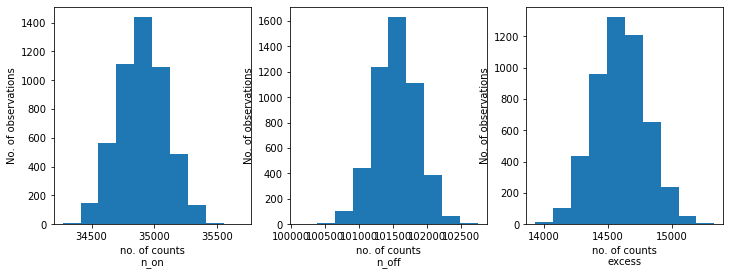

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 16min 53s, sys: 3.84 s, total: 16min 57s
Wall time: 17min 35s


In [15]:
results

[{'index': 2.2065245213780615,
  'amplitude': 1.314624792989545e-12,
  'lambda_': 0.19822373303885332},
 {'index': 2.2241296518600198,
  'amplitude': 1.2597427958332657e-12,
  'lambda_': 0.19849869006038268},
 {'index': 2.2215816290774106,
  'amplitude': 1.2599389030670734e-12,
  'lambda_': 0.20433315945555797},
 {'index': 2.2255111002319556,
  'amplitude': 1.2639165786699223e-12,
  'lambda_': 0.20108668021471066},
 {'index': 2.2405402452329235,
  'amplitude': 1.2800212266093838e-12,
  'lambda_': 0.1987347318716423},
 {'index': 2.196569540293972,
  'amplitude': 1.3394190116344316e-12,
  'lambda_': 0.22642936450661244},
 {'index': 2.25270088300736,
  'amplitude': 1.218659850841904e-12,
  'lambda_': 0.1711351607368041},
 {'index': 2.2179245864540587,
  'amplitude': 1.3006138000014736e-12,
  'lambda_': 0.20956042677926046},
 {'index': 2.2087873646636726,
  'amplitude': 1.2841801081009587e-12,
  'lambda_': 0.19274956641335284},
 {'index': 2.249279839203157,
  'amplitude': 1.216292553466284

index: 2.2191725488080674 += 0.015431030640605508


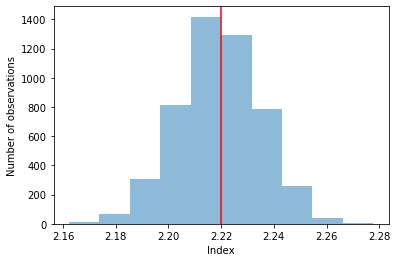

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.291305628914901e-12 += 3.7922224308581826e-14


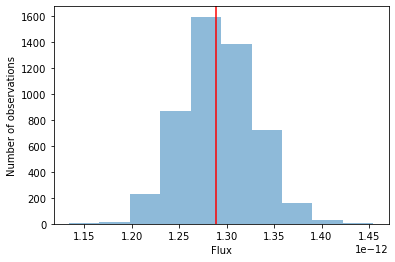

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.2008931265950793 += 0.015414085380664298


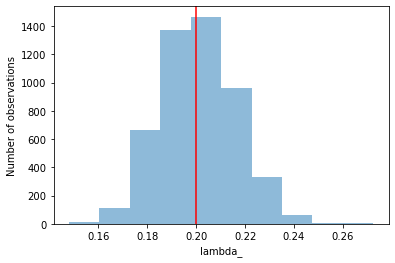

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")